# Trist'n Joseph - IST664 - Final Project

## Set Up

In [1]:
import os

import string
import re
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import treebank
from nltk.corpus import sentence_polarity

from textblob import TextBlob

import random

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
def ug__regex_pattern_match(words):
    """
    """    
    ug__regex_pattern = re.compile('^[^a-z]+$')
    if (ug__regex_pattern.match(words)):
        return True
    else:
        return False
    
def bg__regex_tokenize(words):
    """
    """  
    pattern = r''' (?x)
        (?:[A-Z]\.)+
        | (?:--+)
        | \w+(?:-\w+)*        
        | \$?\d+(?:\.\d+)?%?
        | ['\".?!,:;/]+
        | [][.,;â€â€™?():-_%#â€™]
        '''
    
    tokenized_text = nltk.regexp_tokenize(words, pattern)
    
    return tokenized_text

In [3]:
def document_features(document, word_features):
    document_words = set(document)
    #we open a Pytnon dictionary instead of a list
    features = {}
    for word in word_features:
        #checking if the word from word_features matches a word in the document
        features['contains({})'.format(word)] = (word in document_words)
    return features

def bi_document_features(document, bigram_features):
    document_words = list(nltk.bigrams(document))
    features = {}
    for word in bigram_features:
        #boolean logic will retunt 'True' if there is a match, or 'False' if not
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [4]:
def get_sentiment(textsplit_list):
    """
    """
    polarities = []
    polarity_categories = []
    subjectivities = []
    
    textsplit_textblob = [TextBlob(textsplit) for textsplit in textsplit_list]
    
    for blob in textsplit_textblob:
        pol_sub = blob.sentiment
        polarities.append(pol_sub[0])
        subjectivities.append(pol_sub[1])
        
        if pol_sub[0] < 0:
            pol_cat = 'negative'
            
        elif pol_sub[0] > 0:
            pol_cat = 'positive'
        
        else:
            pol_cat = 'neutral'
            
        polarity_categories.append(pol_cat)
        
    output = {
        'polarity': polarities,
        'category': polarity_categories,
        'subjectivity': subjectivities
    }
    
    return output

In [5]:
def clean_text_data(raw_text):
    """
    """
    porter = nltk.PorterStemmer()
    nltkstopwords = nltk.corpus.stopwords.words('english')
    all_stopwords = nltkstopwords + ["MarketWatch", "marketwatch", "mw", "zachs", "zacks", "barron"]
    
    # need to develop different methods for unigrams vs bigrams etc
    # -- unigram
    ug__text_tokenized = nltk.word_tokenize(raw_text)
    ug__text_words = [w.lower() for w in ug__text_tokenized]
    ug__text_words = [porter.stem(word) for word in ug__text_words]
    ug__text_words_filtered = [w for w in ug__text_words if not ug__regex_pattern_match(w)]
    ug__text_words_filtered = [w for w in ug__text_words_filtered if not w in all_stopwords]
    ug__word_frequency_distribution = FreqDist(ug__text_words_filtered)
    
    # -- bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bg__text_tokenized = bg__regex_tokenize(raw_text)
    bg__text_words = [w for w in bg__text_tokenized]
    
    # ---- frequencies
    bg__fnder_freq = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    bg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    bg__scored_freq = bg__fnder_freq.score_ngrams(bigram_measures.raw_freq)
    
    # ---- PMI
    bg__fnder_pmi = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_pmi.apply_freq_filter(5)
    bg__scored_pmi = bg__fnder_pmi.score_ngrams(bigram_measures.pmi)
    
    # -- trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    tg__text_tokenized = bg__regex_tokenize(raw_text)
    tg__text_words = [w for w in tg__text_tokenized]
    
    # ---- frequencies
    tg__fnder_freq = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    tg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    tg__scored_freq = tg__fnder_freq.score_ngrams(trigram_measures.raw_freq)
    
    # ---- PMI
    tg__fnder_pmi = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_pmi.apply_freq_filter(5)
    tg__scored_pmi = tg__fnder_pmi.score_ngrams(trigram_measures.pmi)
    
    # -- output
    od  = {
        'unigrams': {
            'frequency': ug__word_frequency_distribution,
            'tokens': ug__text_tokenized,
            'cleaned_words': ug__text_words_filtered
        },
        'bigrams': {
            'frequency': bg__scored_freq,
            'pmi': bg__scored_pmi,
            'tokens': bg__text_tokenized
        },
        'trigrams': {
            'frequency': tg__scored_freq,
            'pmi': tg__scored_pmi, 
            'tokens': tg__text_tokenized
        }
    }
    return od

In [6]:
spam_data_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Project/FinalProjectData/FinalProjectData/EmailSpamCorpora/corpus/spam"
ham_data_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Project/FinalProjectData/FinalProjectData/EmailSpamCorpora/corpus/ham"

In [7]:
spam_text = []
ham_text = []

for file_name in os.listdir(spam_data_path):
    if file_name.endswith('.txt'):
        f = open(spam_data_path + '/' + file_name, 'r', encoding='latin-1')
        spam_text.append(f.read())
        f.close()
        
for file_name in os.listdir(ham_data_path):
    if file_name.endswith('.txt'):
        f = open(ham_data_path + '/' + file_name, 'r', encoding='latin-1')
        ham_text.append(f.read())
        f.close()

In [8]:
print('{} spam emails were read'.format(len(spam_text)))
print('{} non-spam emails were read'.format(len(ham_text)))

1500 spam emails were read
3672 non-spam emails were read


In [9]:
email_docs = []

for spam in spam_text:
    tokens = bg__regex_tokenize(spam)
    email_docs.append((tokens, 'spam'))
    
for ham in ham_text:
    tokens = bg__regex_tokenize(ham)
    email_docs.append((tokens, 'non-spam'))

In [10]:
random.shuffle(email_docs)

In [11]:
# for email in email_docs[:5]:
#     print(email)

## Grammar Creation

To tag the texts, data cleaning was necessary. I first tokenized all the sentences within each document, tokenized the words within each sentence, and then removed all the relevant stop words. I chose not to perform neither lowercasing nor word stemming because I wanted to preserve as much sentence context as possible. If I performed lowercasing, I would lose context such as sentences ending with capitalized words. Similarly, if I performed word stemming, words such as “vehicle” and “vehicles” would be the same, and I would lose context as to what the sentence was initially referring to.

Once the cleaning was completed, I created grammars that would be used to identify the POS within a phrase or sentence contained with the texts. I defined adjective, adverb, noun, and verb grammars as follows:

- Adjective: a phrase with an adverb followed by an adjective.
- Adverb: a phrase with consecutive adverbs.
- Noun: a phrase with a proper noun; a determiner followed by a noun; or a determiner followed a noun, and a pronoun or a possessive ending.
- Verb: a phrase with a verb followed by a proper noun; a verb followed by a determiner and a noun; or a verb followed by a determiner, a noun, a pronoun or possessive ending, and another noun.


### Adjectives

Adjectives typically modify a noun or pronoun to make a sentence clearer and more specific.

In [12]:
grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}"
chunk_parser_adj = nltk.RegexpParser(grammar_adjph)

### Adverbs

Adverbs are used to modify verbs, adjectives, or other adverbs within a sentence. An adverb usually modifies by explaining how, when, where, why, under what conditions, or to what extent. 

In [13]:
grammar_advph = "ADVPH: {<RB>+<RB>}"
chunk_parser_advph = nltk.RegexpParser(grammar_advph)

### Nouns

A noun is a word that is used to name something. These can include persons, places, things, or ideas. It must be noted that based on the POS tagging algorithm utilized, it is expected that there would be disproportionately more nouns than any other POS identified. 

In [14]:
grammar_nph = "NPH: {<NNP> | <DT>+<NN.?> | <DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_nph = nltk.RegexpParser(grammar_nph)

### Verbs

Verbs typically indicate or describe what the subject (of a sentence) is doing or feeling.

In [15]:
grammar_vph = "VPH: {<VB.?>+<NNP> | <VB.?>+<DT>+<NN.?> | <VB.?>+<DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_vph = nltk.RegexpParser(grammar_vph)

## Sentiment Analysis

### Unigram

In [16]:
all_words = []

for (sentence, category) in email_docs:
    for word in sentence:
        all_words.append(word)
        
top_words = nltk.FreqDist(all_words)
most_common_words = top_words.most_common(2000)
word_features = [word for (word,count) in most_common_words]
len(set(all_words))

50540

In [17]:
featuresets = [(document_features(d, word_features), c) for (d, c) in email_docs]

In [18]:
kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets):
    train_data = np.array(featuresets)[train]
    test_data = np.array(featuresets)[test]
    classifier = nltk.NaiveBayesClassifier.train(train_data)
    sum += nltk.classify.accuracy(classifier, test_data)

#storing the score in a variable 
acc1 = sum/5

print('The accuracy of unigram model is ~{}%'.format(round(acc1 * 100, 3))) 

The accuracy of unigram model is ~94.587%


### Bigram

In [19]:
all_text = spam_text + ham_text
all_text_str = ' '.join([str(element) for element in all_text])

In [20]:
bigram_frequency = clean_text_data(all_text_str)['bigrams']['frequency']

In [21]:
bigram_features = [bigram for (bigram, count) in bigram_frequency[:2000]]
# bigram_features[:30]

In [22]:
bigram_featuresets = [(bi_document_features(d, bigram_features), c) for (d, c) in email_docs]
# bigram_featuresets[0]

In [23]:
kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(bigram_featuresets):
    train_data2 = np.array(bigram_featuresets)[train]
    test_data2 = np.array(bigram_featuresets)[test]
    classifier2 = nltk.NaiveBayesClassifier.train(train_data2)
    sum += nltk.classify.accuracy(classifier2, test_data2)

acc2 = sum/5

print('The accuracy of the bigram model is ~{}%'.format(round(acc2 * 100, 3)))

The accuracy of the bigram model is ~88.378%


## Examining Sentence Types

### Spam

In [24]:
spam_sentences_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in spam_text]
spam_sentences_tagged_text = [nltk.pos_tag(token) for token in spam_sentences_text_tokenized]
spam_sentences_tagged_text[:5]

[[('Subject', 'JJ'),
  (':', ':'),
  ('dobmeos', 'NN'),
  ('with', 'IN'),
  ('hgh', 'JJ'),
  ('my', 'PRP$'),
  ('energy', 'NN'),
  ('level', 'NN'),
  ('has', 'VBZ'),
  ('gone', 'VBN'),
  ('up', 'RP'),
  ('!', '.'),
  ('stukm', 'NN'),
  ('introducing', 'VBG'),
  ('doctor', 'NN'),
  ('formulated', 'VBD'),
  ('hgh', 'JJ'),
  ('human', 'JJ'),
  ('growth', 'NN'),
  ('hormone', 'NN'),
  ('also', 'RB'),
  ('called', 'VBD'),
  ('hgh', 'NN'),
  ('is', 'VBZ'),
  ('referred', 'VBN'),
  ('to', 'TO'),
  ('in', 'IN'),
  ('medical', 'JJ'),
  ('science', 'NN'),
  ('as', 'IN'),
  ('the', 'DT'),
  ('master', 'NN'),
  ('hormone', 'NN'),
  ('.', '.'),
  ('it', 'PRP'),
  ('is', 'VBZ'),
  ('very', 'RB'),
  ('plentiful', 'JJ'),
  ('when', 'WRB'),
  ('we', 'PRP'),
  ('are', 'VBP'),
  ('young', 'JJ'),
  (',', ','),
  ('but', 'CC'),
  ('near', 'IN'),
  ('the', 'DT'),
  ('age', 'NN'),
  ('of', 'IN'),
  ('twenty', 'NN'),
  ('one', 'CD'),
  ('our', 'PRP$'),
  ('bodies', 'NNS'),
  ('begin', 'VBP'),
  ('to', 'TO'),


#### Adverbs

In [25]:
# tagging the adverb phrases 
spam_advph_tags = []
for sentence in spam_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                spam_advph_tags.append(subtree)
                
# visualizing the adverb phrases
spam_advph_phrases = []
for phrase in spam_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    spam_advph_phrases.append(temp)
    
print('First 10 adverb phrases for spam sentences are: ', spam_advph_phrases[:10])

First 10 adverb phrases for spam sentences are:  ['as well ', 'as well ', 'as well ', 'as well ', 'as fast ', 'ass as ', 'rather practically ', 'forever so ', 'as long ', 'right away ']


In [26]:
# examining the freuqncy of the adverb phrases
spam_advph_frequency = nltk.FreqDist(spam_advph_phrases)
spam_advph_frequency_words = []
spam_advph_frequency_fs = []


print('Top adverb phrases for spam sentences by frequency are: ')
for word, freq in spam_advph_frequency.most_common(50):
    spam_advph_frequency_words.append(word)
    spam_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases for spam sentences by frequency are: 
as long  47
as well  35
as soon  24
not only  14
right now  14
here now  9
not later  9
once again  8
here not  5
very quickly  5
so here  5
not immediately  5
not completely  5
not yet  4
quick now  4
not currently  4
not just  4
really surprisingly  4
only as  3
twice as  3
so much  3
only here  3
very well  3
directly instead  3
right away  2
rather not  2
also strongly  2
right here  2
ever again  2
not even  2
not as  2
as much  2
s too  2
very fast  2
very soon  2
here upload  2
so long  2
almost anywhere  2
then ever  2
just simply  2
not too  2
maybe not  2
i now  2
now so  2
usually only  2
up over  2
currently ahead  2
only approximately  2
as fast  1
ass as  1


Text(0.5, 1.0, 'Distribution of (Top 20) Spam Adverb Phrases')

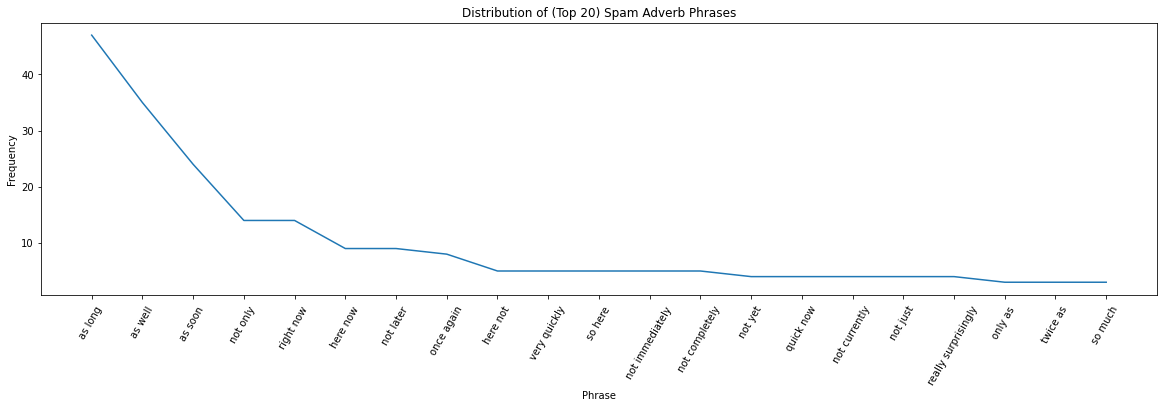

In [27]:
fig = plt.figure(figsize = (20, 5))
plt.plot(spam_advph_frequency_words[:21], spam_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Spam Adverb Phrases')

#### Nouns

In [28]:
# tagging the noun phrases 
spam_nph_tags = []
for sentence in spam_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                spam_nph_tags.append(subtree)
                
# visualizing the noun phrases
spam_nph_phrases = []
for phrase in spam_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    spam_nph_phrases.append(temp)
    
print('First 10 noun phrases for spam sentences are: ', spam_nph_phrases[:10])

First 10 noun phrases for spam sentences are:  ['the master ', 'the age ', 'the time ', 'this website ', 'an fda ', 'no thanks ', 'a team ', 'the senate ', 'the moment ', 'a matter ']


In [29]:
# examining the freuqncy of the noun phrases
spam_nph_frequency = nltk.FreqDist(spam_nph_phrases)
spam_nph_frequency_words = []
spam_nph_frequency_fs = []


print('Top noun phrases for spam sentences by frequency are: ')
for word, freq in spam_nph_frequency.most_common(50):
    spam_nph_frequency_words.append(word)
    spam_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases for spam sentences by frequency are: 
/  1964
=  988
_  694
the company  345
@  205
this report  201
this message  163
this email  147
a href  142
"  114
the securities  110
this newsletter  97
this link  77
the publisher  77
the world  74
the link  71
x  65
the time  64
the statements  62
no thanks  61
the information  57
the meaning  57
this stock  57
the internet  56
xp  54
the stock  52
???  52
a number  50
this mail  49
this list  47
the address  45
the material  45
\  44
the use  44
the property  43
these companies  43
no prescription  42
all logos  42
any kind  41
the request  41
all prices  41
xanax  40
any complaints  40
the news  38
the money  36
middle  35
no assurance  35
the results  34
the market  34
any time  33


Text(0.5, 1.0, 'Distribution of (Top 20) Spam Noun Phrases')

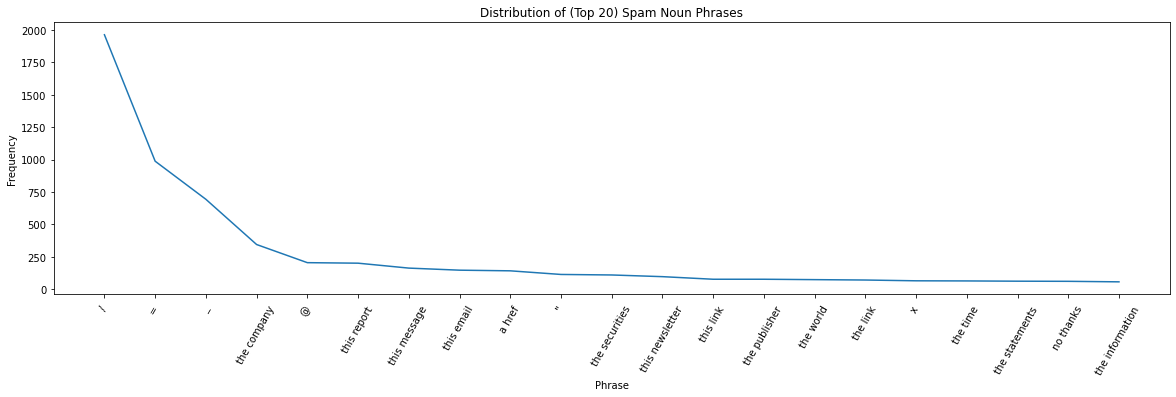

In [30]:
fig = plt.figure(figsize = (20, 5))
plt.plot(spam_nph_frequency_words[:21], spam_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Spam Noun Phrases')

#### Verbs

In [31]:
# tagging the noun phrases 
spam_vph_tags = []
for sentence in spam_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                spam_vph_tags.append(subtree)
                
# visualizing the noun phrases
spam_vph_phrases = []
for phrase in spam_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    spam_vph_phrases.append(temp)
    
print('First 10 verb phrases for spam sentences are: ', spam_vph_phrases[:10])

First 10 verb phrases for spam sentences are:  []


### Ham

In [32]:
ham_sentences_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in ham_text]
ham_sentences_tagged_text = [nltk.pos_tag(token) for token in ham_sentences_text_tokenized]
ham_sentences_tagged_text[:5]

[[('Subject', 'JJ'),
  (':', ':'),
  ('christmas', 'NN'),
  ('tree', 'NN'),
  ('farm', 'NN'),
  ('pictures', 'NNS')],
 [('Subject', 'JJ'),
  (':', ':'),
  ('vastar', 'NN'),
  ('resources', 'NNS'),
  (',', ','),
  ('inc', 'NN'),
  ('.', '.'),
  ('gary', 'NN'),
  (',', ','),
  ('production', 'NN'),
  ('from', 'IN'),
  ('the', 'DT'),
  ('high', 'JJ'),
  ('island', 'NN'),
  ('larger', 'JJR'),
  ('block', 'VB'),
  ('a', 'DT'),
  ('1', 'CD'),
  ('#', '#'),
  ('2', 'CD'),
  ('commenced', 'VBD'),
  ('on', 'IN'),
  ('saturday', 'NN'),
  ('at', 'IN'),
  ('2', 'CD'),
  (':', ':'),
  ('00', 'CD'),
  ('p', 'NN'),
  ('.', '.'),
  ('m', 'NN'),
  ('.', '.'),
  ('at', 'IN'),
  ('about', 'IN'),
  ('6', 'CD'),
  (',', ','),
  ('500', 'CD'),
  ('gross', 'JJ'),
  ('.', '.'),
  ('carlos', 'NN'),
  ('expects', 'VBZ'),
  ('between', 'IN'),
  ('9', 'CD'),
  (',', ','),
  ('500', 'CD'),
  ('and', 'CC'),
  ('10', 'CD'),
  (',', ','),
  ('000', 'CD'),
  ('gross', 'JJ'),
  ('for', 'IN'),
  ('tomorrow', 'NN'),
  ('

#### Adverbs

In [33]:
# tagging the adverb phrases 
ham_advph_tags = []
for sentence in ham_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                ham_advph_tags.append(subtree)
                
# visualizing the adverb phrases
ham_advph_phrases = []
for phrase in ham_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    ham_advph_phrases.append(temp)
    
print('First 10 adverb phrases for non-spam sentences are: ', ham_advph_phrases[:10])

First 10 adverb phrases for non-spam sentences are:  ['as soon ', 'currently still ', 'then once again ', 'so much ', 'not only ', 'as well ', 'not only ', 'as well ', 'nom here ', 'just now ']


In [34]:
# examining the freuqncy of the adverb phrases
ham_advph_frequency = nltk.FreqDist(ham_advph_phrases)
ham_advph_frequency_words = []
ham_advph_frequency_fs = []


print('Top adverb phrases for non-spam sentences by frequency are: ')
for word, freq in ham_advph_frequency.most_common(50):
    ham_advph_frequency_words.append(word)
    ham_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases for non-spam sentences by frequency are: 
as well  122
as soon  111
well meter  44
not yet  24
right now  20
no longer  20
once again  16
not only  14
as long  12
back up  11
so far  10
as far  9
just now  8
very much  8
well only  8
so much  7
not enough  7
nom here  6
again soon  6
not just  6
just not  6
forward back  5
not currently  5
no later  5
thus far  5
however i  5
not necessarily  5
not already  5
molly carriere  4
so here  4
far back  4
so long  4
not even  4
quite nicely  4
there as well  3
once again not  3
not legally  3
not as  3
so late  3
i just  3
pretty well  3
right away  3
as promptly  3
not completely  3
not up  3
just simply  3
just as  3
very carefully  3
only once  3
not properly  3


Text(0.5, 1.0, 'Distribution of (Top 20) Non-Spam Adverb Phrases')

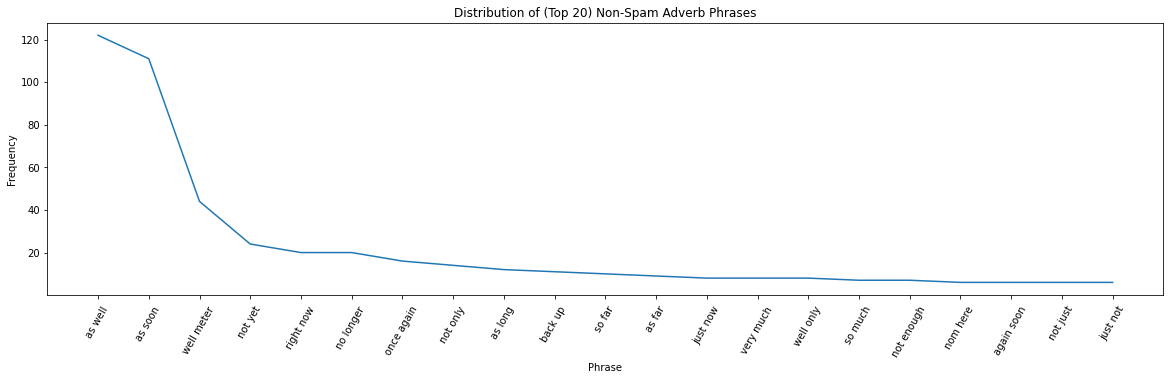

In [35]:
fig = plt.figure(figsize = (20, 5))
plt.plot(ham_advph_frequency_words[:21], ham_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Non-Spam Adverb Phrases')

#### Nouns

In [36]:
# tagging the noun phrases 
ham_nph_tags = []
for sentence in ham_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                ham_nph_tags.append(subtree)
                
# visualizing the noun phrases
ham_nph_phrases = []
for phrase in ham_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    ham_nph_phrases.append(temp)
    
print('First 10 noun phrases for non-spam sentences are: ', ham_nph_phrases[:10])

First 10 noun phrases for non-spam sentences are:  ['/ ', '/ ', '/ ', '/ ', '/ ', '@ ', '/ ', '/ ', '@ ', '/ ']


In [37]:
# examining the freuqncy of the noun phrases
ham_nph_frequency = nltk.FreqDist(ham_nph_phrases)
ham_nph_frequency_words = []
ham_nph_frequency_fs = []


print('Top noun phrases for non-spam sentences by frequency are: ')
for word, freq in ham_nph_frequency.most_common(50):
    ham_nph_frequency_words.append(word)
    ham_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases for non-spam sentences by frequency are: 
/  20085
@  9721
>  3571
=  1609
_  1502
"  727
any questions  513
the deal  464
the gas  356
the month  304
this deal  233
the meter  219
this meter  212
a deal  209
the plant  173
the volumes  171
the contract  167
the volume  158
the price  158
this gas  137
a hanks  133
the system  131
enron  115
a call  115
the office  103
the end  100
the sale  98
this issue  97
the following  94
the "  92
a price  89
the time  86
the purchase  86
these volumes  85
the information  84
these deals  83
this email  83
the above  82
the gathering  78
[  77
the redeliveries  75
the demand  75
the texas  68
this time  67
the deals  67
a copy  66
the transport  66
a list  65
a ticket  65
the transaction  63


Text(0.5, 1.0, 'Distribution of (Top 20) Non-Spam Noun Phrases')

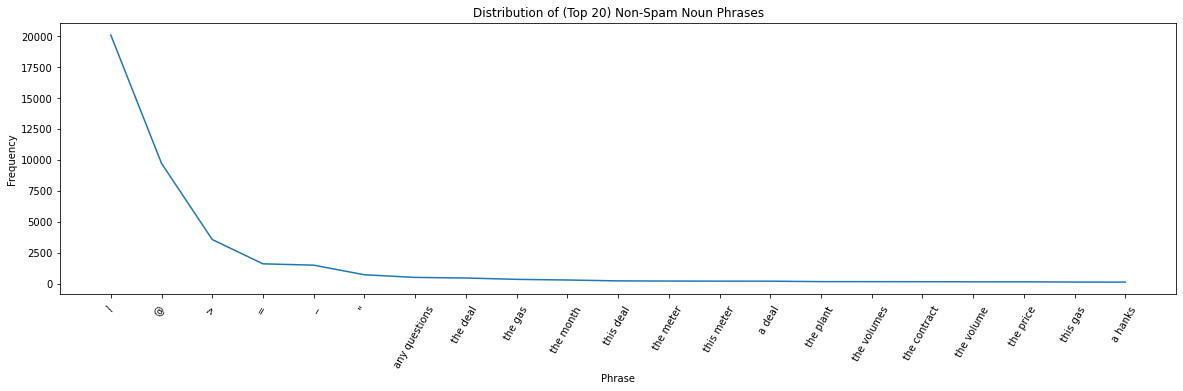

In [38]:
fig = plt.figure(figsize = (20, 5))
plt.plot(ham_nph_frequency_words[:21], ham_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Non-Spam Noun Phrases')

#### Verbs

In [39]:
# tagging the noun phrases 
ham_vph_tags = []
for sentence in ham_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                ham_vph_tags.append(subtree)
                
# visualizing the noun phrases
ham_vph_phrases = []
for phrase in ham_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    ham_vph_phrases.append(temp)
    
print('First 10 verb phrases for non-spam sentences are: ', ham_vph_phrases[:10])

First 10 verb phrases for non-spam sentences are:  []
